# American Options

For options that can be hedged perfectly and dynamically during their life using cash and units of the underlying asset, we can use risk-neutral pricing to derive the arbitrage-free (fair) value as the discounted expectation of the final payoff under a risk-neutral probability measure $\mathbb{Q}$:

$$V_0=e^{-rT}\mathbb{E}^\mathbb{Q}\left[V_{T}|\mathcal{F_0}\right]$$

If this expectation does not have a closed-form solution, we can approximate it using Monte-Carlo methods. <br>American options however, are path-dependent options that cannot be perfectly hedged dynamically during their life (Sub-martingales). The early exercise feature of American options makes the hedging & pricing problem more complicated. For path-dependent options we cannot apply risk-neutral pricing under the measure $\mathbb{Q}$. In this case, the application of Monte-Carlo methods is not obvious.

## American Options Pricing with Dynamic Programming Design

Let $V\left(i, S_i\right)$ denote the value (price) of the American option at the time node $i$ given that the underlying spot price is $S_i$ at that time node. Also, let $h(s)=f(s|S_i=s)$ denote the **Intrinsic Value** (Early Exercise value) of the option at the time node $i$, i.e. the payoff from the immediate exercise. 

Define, $$CV\left(i, s\right)=e^{-r\Delta t}\mathbb{E}^{\mathbb{Q}}\left[V\left(i+1, S_{i+1}\right)|S_i=s\right]\;,$$ 

as the **Continuation Value** at the time node $i$, i.e., the value from holding the option and not exercising.<br>

Then, if we fix the set of all the possible exercise dates $\{0<t_1<t_2<...<t_i<...<t_n=T\},$ we could use a **Dynamic Programming Backward Recurion** approach:

$$V\left(i, s\right)=max\left[h(s), CV\left(i, s\right)\right]\;,\text{ for }i=n-1:0,\;\text{ and boundary condition }V\left( n,s\right)=h(s)$$

to recover the option value at previous nodes. Essentially, we are saying that the value of the "game" at the time node $i$ given $S_i=s$, is the **maximum** between **stopping the game and receiving the immediate payoff** and **the expected value of playing another round of the game**.

We can then define an optimal stopping time, $\tau^*=\inf\{t_i: V(i, S_i)=h(S_i)\}$

For example, at the immediate time node before expiry, we would have,

$$V(n-1, s)=max\left[h(s), e^{-r \Delta t}\mathbb{E}\left[V(n,S_n)|S_{n-1}=s\right]\right]$$

The main difficulty (as always) in the dynamic programming pricing scheme is to **estimate the conditional expectation in the continuation value**:

$$\mathbb{E}\left[V\left(i+1, S_{i+1}\right)|S_i=s\right]$$



## CRR Binomial Tree for approximating the Conditional Expectation

We can use the CRR Binomial Tree to compute the conditional expectation $\mathbb{E}\left[V\left(i+1, S_{i+1}\right)|S_i=s\right]$ at each time node $i=n-1:0$ and then price the American options using the dynamic programming backward recursion described above. 

In the binomial tree framework, at each time node $i$, the underlying asset price can increase by $(u-1)$% or decrease by $(1-d)$%, where $u=e^{\sigma \Delta t}$ and $d=\frac{1}{u}$. The size of each time step is $\Delta t$ and we have a total of $n=\frac{T}{\Delta T}$ time steps and thus n+1 time nodes.

Now, recall that under the risk-neutral probability measure $\mathbb{Q}$ the discounted asset price is a $\mathbb{Q}$-Martingale:

$\mathbb{E}^\mathbb{Q}\left[\overline{S_{i+1}}|\mathcal{F_i}\right]=\overline{S_i}\implies S_ie^{-r \Delta t}=\mathbb{E}^\mathbb{Q}\left[e^{-r(i+1) \Delta t}S_{i+1}|\mathcal{F_i}\right] \implies S_i=e^{-r \Delta t } \mathbb{E}^\mathbb{Q}\left[S_{i+1}|\mathcal{F_i}\right]$ from which we can easily extract the risk-neutral probabilities as:

$S_i=e^{-r \Delta t } \left[qS_iu+(1-q)S_id\right] \implies q=\frac{e^{r \Delta t}-d}{u-d}\;\text{with }u=e^{\sigma\sqrt{\Delta t}}\text{ and }d=\frac{1}{u}$.

The above constitutes the CRR binomial tree parametrization and is in fact related to a Monte Carlo method for options pricing with underlying asset SDE under measure $\mathbb{Q}$: $\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$ and discrete simulation scheme: 
$$S_{i+1}= \begin{cases}S_iu,\; q\\S_id,\;(1-q)\end{cases}\;,$$ from which it easy to check that $\mathbb{E}^\mathbb{Q}\left[S_{i+1}|\mathcal{F_i}\right]=S_ie^{r \Delta t }$. As the number of the time steps $n$ is increased, the CRR binomial price will converge to the continuous-time price. Then, it follows that the conditional expectation is given as: 

$$\mathbb{E}^{\mathbb{Q}}\left[V\left(i+1, S_{i+1}\right)|S_i=s\right]=qV\left(i+1, su\right)+(1-q)V\left(i+1, sd\right)$$

Then, under the CRR binomial tree parametrization, we can use the dynamic programmng approach and recover the American option's price at all time nodes using the backwards recursion: $$V(i, s) = \max \left[ h(s),\;e^{-r\Delta t} \left[ qV(i+1, su) + (1-q)V(i+1, sd) \right] \right]\text{ for }i=(n-1):0$$ 

and boundary condition (at expiry) $V(n,s)=h(s)$


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

# CRR Binomial Tree-based pricing methods

### Routine for populating the CRR Binomial Tree with underlying prices

In [36]:

def crr_binomial_tree(S0, T, dt, r, q, sigma):
    
    """ Plain routine to fill the CRR Binomial Tree """
    
    # CRR Parametrization
    n = int(T / dt)
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    
    # Initialize the vector of the underlying asset price
    S = np.zeros((n + 1, n + 1))
    S[0, 0] = S0
    
    # Loop through the time nodes from the 2nd to the last - index j 
    for j in range(1, S.shape[0]):
        
        # Fill the asset values at the point nodes of the given time node - index i
         for i in range(j + 1):
                
            """
            At the time node j, index i counts the downward moves and so (j - i) counts the upward moves,
            since we can have at most j moves in j steps.
            """   
            
            S[i, j] = S0 * (u ** (j - i)) * (d ** i) 
   
    return S


###  Vectorized Version

In [4]:

def crr_vectorized_binomial_tree(S0, T, dt, r, q, sigma):
    
    """ Efficient vectorized routine to compute the CRR Binomial Tree """
    
    # CRR Parametrization
    n = int(T / dt)
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    
    # Initialize the vector of the underlying asset price
    S =np.zeros((n + 1, n + 1))
    S[0, 0] = S0  
    
    # Loop through the time nodes
    for j in range(1, S.shape[0]):
        
        """ 
        At each time node j, we shift all the points of time node (j - 1) up by a factor of u. (The non-zero elements)
        Then we shift the last point of the time node (j - 1) down by a factor of d.
        
        * We do not use [:, j - 1], [: -1, j - 1] or [-1, j - 1] indexing because it is a lattice and includes "0" elements.
        
        """
        
        # Shift all the non-zero points of the previous node up by a factor of u
        S[: j, j] = u * S[: j, j - 1]
    
        # Shift the last non-zero point of the previous time node down by a factor of d
        S[j, j] = d * S[j - 1, j - 1]
        
    return S

### Routine for Dynamic Programming Options Pricing (Vectorized)

In [5]:

def american_option_dynamic_prog(S, K, T, dt, r, q, sigma, flag):

    # Initial CRR parametrization
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    disc = exp(-r * dt)
    
    # Risk-neutral probabilities
    p = (exp((r - q) * dt) - d) / (u - d)
    
    
    # Initialize the vector of the option prices
    V = np.zeros(S.shape)
    
    """ If flag "Call", price an American Call """
    
    if flag == "c":

        # Boundary Condition at the Maturity
        V[: , -1] = np.maximum(S[:, -1] - K, 0)
        
        """Dynamic programming backward recursion to recover the option values:
               
               Work backwards for j = n : 1 and recover the option values at each node as:
               
               V(j - 1, s) = max[EE(s), CV(j - 1, s)] ,
               
               where CV(j - 1, s) = disc *p * (V(j, s*u) +(1 - p) * V(j, s*d))
               
        """
        
        for j in range(V.shape[0] - 1, 0, -1):  
            
            """
            Continuation Value at time node (j - 1) using vectorized calculation:
            
            Multiply the first (j - 1) points with q and the (1: j) points by (1-q) of time node j, and sum them.
            Assign the result to the continuation values of node (j-1).
            
            """
            # Vectorized continuation value at time node (j - 1)
            V[: j, j - 1] = disc * (p * V[: j, j] + (1 - p) * V[1: j + 1 : , j])

            # Early-Exercise value at time node (j - 1)
            EE = np.maximum(S[: , j - 1] - K, 0)

            # Find the points of time node (j - 1) where it is optimal to exercise early
            ind = EE > V[: , j - 1]
            
            # Assign to these points the Early-Exercise value
            V[ind, j - 1] = EE[ind]
    
    
        """ If flag "Put", price an American Put """
    
    else: 
        
        """
        Exactly the same code as above with adjusted boundary condition and early exercise value to a put
        """
        
        # Boundary Condition
        V[: , -1] = np.maximum(K - S[:, -1], 0)
        
        # Dynamic programming backward recursion
        for j in range(V.shape[0] - 1, 0, -1):

            # Continuation Value
            V[: j, j - 1] = disc * (p * V[: j, j] + (1 - p) * V[1: j + 1 : , j])
            
            # Early-Exercise Value
            EE = K - S[: , j - 1]
            
            # Find the points of time node (j - 1) where it is optimal to exercise early
            ind = EE > V[: , j - 1]
            
            # Assign to these points the Early-Exercise value
            V[ind, j - 1] = EE[ind]
        
    
    return V


### CRR Binomial Tree Price

In [59]:

# Initial CRR Parameters

T = 1
dt = 1 / 365
S0 = 70
sigma = 0.3
q = 0
r = 0.05
disc = exp(-r * dt)
K = 100

# Binomial prices
S = crr_vectorized_binomial_tree(S0, T, dt, r, q, sigma)

# American option price
V = american_option_dynamic_prog(S, K, T, dt, r, q, sigma, flag="p").round(4)
print(f"\nThe CRR Binomial Price of the put is: {V[0, 0]:.3f}")



The CRR Binomial Price of the put is: 30.008


### Estimate the Early-Exercise Region from the CRR Bionomial tree

In [60]:

u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
p = (np.exp(dt * (r - q)) - d) / (u - d)
n = round( T / dt)

ee_region_bin = np.zeros(n)

# Estimate the Early Exercise region:
for i in range(n - 1, -1, -1):
    
    for j in range(i + 1):
        
        exercise = max(0, K - S[j, i])
        
        continue_val = disc * (p * V[j, i + 1] + (1 - p) * V[j + 1, i + 1])
        
        if exercise > continue_val:
            
            ee_region_bin[i] = S[j, i]
            break

ee_region_bin[0] = S0


# Least Squares Monte-Carlo

## LSMC with Raw Polynomial Basis Design $d=6$

In [9]:

# LSMC Function for American Put with Raw Polynomial Basis expansion
def LSMC_put_func(S, K, D):
    n = S.shape[1]
    payoff = np.maximum(K - S, 0)
    V = np.zeros_like(S)
    V[:, -1] = payoff[:, -1]  # Terminal Value

    # Backward Regression
    
    for j in range(n - 1, 0, -1):
        V[:, j - 1] = V[:, j] * D
        ind = payoff[:, j - 1] > 0  # ITM Samples, we consider only those
        # LSMC Regression for ITM Samples
        # Design Matrix with 6th Degree Polynomial
        # Evaluated at t-1
        psi = np.vander(S[ind, j - 1], 7, increasing=True)
        # Backward Regression with pseudo-inverse
        b = np.linalg.pinv(psi) @ V[ind, j]
        # Continuation Value at time t-1
        CV = D * psi @ b
        V[ind, j - 1] = np.maximum(CV, payoff[ind, j - 1])
    
    
    LSMC_Prc = np.mean(V[:, 0])
    return LSMC_Prc, V, S


### Price the American Put

In [53]:

# Parameters
S0 = 70
K = 100
T = 2
r = 0.05
q = 0.0
sigma = 0.3
n = 365  # number of time steps
dt = T / n
N = 100000  # number of simulation paths

D = np.exp(-r * dt)

# Simulate the underlying asset paths via GBM
S = np.zeros((N, n))
S[:, 0] = S0

for j in range(1, n):
    S[:, j] = S[:, j - 1] * np.exp((r - q - 0.5 * sigma ** 2) * dt +
                                   sigma * np.random.randn(N) * np.sqrt(dt))

# Compute the Put LSMC Price
LSMC_Prc, V, S = LSMC_put_func(S, K, D)

print(f"\nThe LSMC Put Price is : {LSMC_Prc:.3f}")



The LSMC Put Price is : 30.430


## LSMC with Orthogonal Basis expansion via Hermite Polynomials

In [45]:

# Function to compute the coefficients of the phycisists' Hermite polynomials

def hermipol(d):
    
    import scipy
    
    h = np.zeros((d + 1, d + 1))
    
    for i in range(d + 1):
    
        h[i, -(i + 1):] = np.array(scipy.special.hermite(i))     
    
    h = np.where(abs(h )< 1e-8, 0, h )
    
    return h


In [46]:

# LSMC Routine with Orthogonal Basis Expansion via Hermite Polynomials

def LSMC_put_func_herm(S, K, D, d):
    
    
    n = S.shape[1]
    payoff = np.maximum(K - S, 0)
    V = np.zeros_like(S)
    V[:, -1] = payoff[:, -1]  # Terminal Value

    # Backward Regression
    for j in range(n - 1, 0, -1):
        
        V[:, j - 1] = V[:, j] * D
        ind = payoff[:, j - 1] > 0  # ITM Samples, we consider only those
        # LSMC Regression for ITM Samples
        # Design Matrix with 6th Degree Polynomial
        # Evaluated at t-1
        
        # Coefficient matrix of the Hermite Polynomials
        p = hermipol(d)
        
        # Dimensions of the design matrix
        psi = np.zeros((sum(ind), d + 1))
        
        for i in range(d + 1):
            
            psi[: , i] = np.polyval(p[i, :], np.log(S[ind , j - 1]));
            
        
        # Backward Regression with pseudo-inverse
        b = np.linalg.pinv(psi) @ V[ind, j]
        # Continuation Value at time t-1
        CV = D * psi @ b
        V[ind, j - 1] = np.maximum(CV, payoff[ind, j - 1])

    LSMC_Prc = np.mean(V[:, 0])
    
    return LSMC_Prc, S, V


### Price the American Put

In [61]:


# Parameters
S0 = 70
K = 100
T = 1
r = 0.05
q = 0.0
sigma = 0.3
n = 365  # number of time steps
dt = T / n
N = 100000  # number of simulation paths
D = np.exp(-r * dt)

# Simulate the underlying asset paths via GBM
S = np.zeros((N, n))
S[:, 0] = S0

for j in range(1, n):
    S[:, j] = S[:, j - 1] * np.exp((r - q - 0.5 * sigma ** 2) * dt +
                                   sigma * np.random.randn(N) * np.sqrt(dt))

# Compute the LSMC Put price
price, S, V = LSMC_put_func_herm(S, K, D, 8)

print(f"The LSMC Price with Hermite Polynomials: {price: .3f}")


The LSMC Price with Hermite Polynomials:  30.025


### Estimate the Early Exercise Region as a function of $t$

In [62]:

# Extract the estimated Early-Exercise Region of the American Put
ee_value_lsmc = np.zeros((S.shape[0], n));
ee_region = np.zeros(n);


for j in range(n - 1, 0, -1):
    
    ind = (np.maximum((K - S[: , j]), 0) == V[: , j]) & (S[: , j] < K)
    ee_value_lsmc[ind, j] = S[ind, j];
    ind2 = ee_value_lsmc[: , j] != 0;
    temp = ee_value_lsmc[ind2, j];
    
    if len(temp) > 0:
        ee_region[j] = np.quantile(temp, 0.95 + 0.05 * j / n);

ee_region[0] = S0


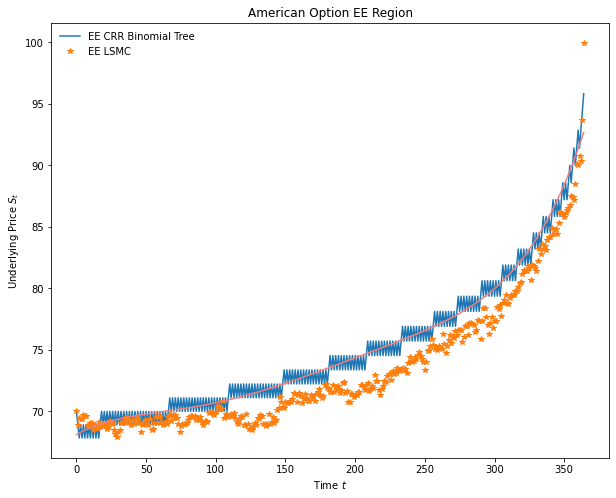

In [63]:

# Plot the Early exercise region 
x = np.linspace(0, T, n)

# Fit a 5th degree polynomial to the estimated early exercise region
poly_coeffs = np.polyfit(x,ee_region_bin, deg = 5)

# Evaluate the polynomial values at the x points
poly_fit = np.polyval(poly_coeffs, x)


# Plot the estimated regions
plt.figure(figsize=(10, 8))
plt.plot(ee_region_bin, label ="EE CRR Binomial Tree")
plt.plot(ee_region, marker="*", linestyle = " ", label = "EE LSMC")

plt.plot(poly_fit, color = "lightcoral")
plt.legend(frameon = False)
plt.title("American Option EE Region")
plt.ylabel("Underlying Price $S_t$")
plt.xlabel("Time $t$")
plt.plot()
plt.show()